### Imports

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('movie_reviews')
nltk.download('word2vec_sample')

from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import string
import re
from nltk.stem import PorterStemmer
from nltk.data import find

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


### Data Exploration

In [ ]:
# Get positive and negative movie reviews
positive_reviews = movie_reviews.fileids('pos')
negative_reviews = movie_reviews.fileids('neg')

# Print the number of positive and negative reviews
print("Number of positive reviews:", len(positive_reviews))
print("Number of negative reviews:", len(negative_reviews))

# Get all words
all_words = movie_reviews.words()

# Print the number of words for all, positive, and negative reviews
print("Total number of words: ", len(all_words))
print("Number of words in positive reviews:", sum(1 for fileid in positive_reviews for _ in movie_reviews.words(fileid)))
print("Number of words in negative reviews:", sum(1 for fileid in negative_reviews for _ in movie_reviews.words(fileid)))

# Print the 15 most common words for positive and negative reviews before preprocessing
pos_words = [word.lower() for fileid in positive_reviews for word in movie_reviews.words(fileid)]
neg_words = [word.lower() for fileid in negative_reviews for word in movie_reviews.words(fileid)]

fdist_pos = FreqDist(pos_words)
fdist_neg = FreqDist(neg_words)

print("Most common words in positive reviews:", fdist_pos.most_common(15))
print("Most common words in negative reviews:", fdist_neg.most_common(15))

Number of positive reviews: 1000
Number of negative reviews: 1000
Total number of words:  1583820
Number of words in positive reviews: 832564
Number of words in negative reviews: 751256
Most common words in positive reviews: [(',', 42448), ('the', 41471), ('.', 33714), ('a', 20196), ('and', 19896), ('of', 18636), ('to', 16517), ("'", 15268), ('is', 14059), ('in', 11725), ('s', 9659), ('"', 8492), ('it', 8351), ('that', 8121), ('-', 7931)]
Most common words in negative reviews: [(',', 35269), ('the', 35058), ('.', 32162), ('a', 17910), ('and', 15680), ('of', 15487), ('to', 15420), ("'", 15317), ('is', 11136), ('in', 10097), ('"', 9120), ('s', 8854), ('that', 7803), ('it', 7756), ('-', 7664)]


### Preprocessing
This code defines a preprocessing function for natural language text, whith options to tokenize, remove punctuation, convert words to lowercase, lemmatize them, remove short words, and filter out stopwords. It's then applied to movie reviews from a corpus to preprocess them for further analysis.

In [ ]:
# Preprocessing function
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    """Lemmatize a word using WordNet Lemmatizer"""
    return lemmatizer.lemmatize(word) if word else None

def tokenize(text):
    """Tokenize the input text into words"""
    return word_tokenize(text)

def remove_punctuation(word):
    """Remove punctuation from a word"""
    return ''.join([char for char in word if char not in string.punctuation]) if word else None

def remove_stopwords(word):
    """Remove stopwords from a word"""
    return word if word not in stop_words else None

def remove_short_words(word, length=1):
    """Remove words with length less than length"""
    return word if word and len(word) > length else None

def stem_word(word):
    """Stem a word using Porter Stemmer"""
    return porter.stem(word) if word else None

def remove_non_alphabetic(word):
    """Remove non-alphabetic characters from a word using regex"""
    return re.sub(r'[^a-zA-Z]', '', word) if word else None

def preprocess_words(words):
    # Tokenize the input text into words
    words = tokenize(words)
    preprocessed_words = []

    # Iterate over each word in the tokenized words
    for word in words:
        # Convert the word to lowercase
        word = word.lower()

        #word =  remove_stopwords(word)
        word = remove_punctuation(word)
        #word = remove_non_alphabetic(word)
        word = lemmatize_word(word)
        #word = stem_word(word)
        word = remove_short_words(word, length = 2)
        if word:
            preprocessed_words.append(word)

    return preprocessed_words

# Accessing movie reviews from the corpus
reviews = [movie_reviews.raw(fileid) for fileid in movie_reviews.fileids()]
preprocessed_reviews = [preprocess_words(review) for review in reviews]

print(f"Original Review:\n{reviews[1]}\n")
print("Preprocessed Review:\n", ' '.join(preprocessed_reviews[1]))

Original Review:
the happy bastard's quick movie review 
damn that y2k bug . 
it's got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on . 
little do they know the power within . . . 
going for the gore and bringing on a few action sequences here and there , virus still feels very empty , like a movie going for all flash and no substance . 
we don't know why the crew was really out in the middle of nowhere , we don't know the origin of what took over the ship ( just that a big pink flashy thing hit the mir ) , and , of course , we don't know why donald sutherland is stumbling around drunkenly throughout . 
here , it's just " hey , let's chase these people around with some robots " . 
the acting is below average , even from the likes of curtis . 
you're more likely to get a kick out of h

## Vectorization

This code segment allows for the selection and utilization of either a pre-trained Word2Vec model or a custom-trained one on preprocessed movie review data. It then calculates the similarity between specified positive and negative words, generates word vectors for each review, and organizes them along with their corresponding labels into a DataFrame for further analysis.

In [ ]:
# @title  { vertical-output: true }
import numpy as np
from gensim.models import Word2Vec
import gensim
import gensim.downloader

model_choice = "Pretrained Model - Sample" # @param ["Train Model", "Pretrained Model - Twitter", "Pretrained Model - Sample"]

if model_choice == "Train Model":
  # Train Word2Vec model
  # Function to merge "not" with the following word
  def merge_not(review):
      return re.sub(r'\b(not)\s+(\w+)\b', r'\1-\2', ' '.join(review)).split()

  # Apply merge_not function to each review
  #preprocessed_reviews = [merge_not(review) for review in preprocessed_reviews]
  #preprocessed_reviews = [['negative'] + review for review in preprocessed_reviews[:1000]] + [['positive'] + review for review in preprocessed_reviews[1000:]]

  model = Word2Vec(preprocessed_reviews, min_count = 1, vector_size=256, workers=4).wv

elif model_choice == "Pretrained Model - Twitter":
  # Load the pre-trained Word2Vec model
  #print(list(gensim.downloader.info()['models'].keys())) All the pretrained models
  model = gensim.downloader.load('glove-twitter-25')

else:
  word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
  model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

positive_word = "good"
negative_word = "bad"

print(f"Words most similar to {positive_word}:")
print(model.most_similar(positive_word))
print(f"Words most similar to {negative_word}:")
print(model.most_similar(negative_word))

# Calculate the average of word vectors for each review
review_vectors = []
for review in preprocessed_reviews:
    review_word_vectors = [model[word] for word in review if word in model]
    if review_word_vectors:
        review_vector = np.mean(review_word_vectors, axis=0)
        review_vectors.append(review_vector)

print("\nVector for first review:")
print(review_vectors[0])

# Convert the list of review vectors to df
reviews_df = pd.DataFrame(review_vectors)

# Create Labels (since the movie reviews are sorted, one can just add the labels like this)
labels = [0] * 1000 + [1] * 1000
reviews_df['label'] = labels

Words most similar to good:
[('great', 0.7291511297225952), ('bad', 0.7190051674842834), ('terrific', 0.6889115571975708), ('decent', 0.6837347149848938), ('nice', 0.6836092472076416), ('excellent', 0.6442930102348328), ('fantastic', 0.6407780051231384), ('better', 0.6120728254318237), ('solid', 0.5806035995483398), ('lousy', 0.576420247554779)]
Words most similar to bad:
[('good', 0.7190050482749939), ('terrible', 0.6828613877296448), ('horrible', 0.6702598333358765), ('Bad', 0.669891893863678), ('lousy', 0.6647642254829407), ('crummy', 0.5677821040153503), ('horrid', 0.5651683211326599), ('awful', 0.5527254343032837), ('dreadful', 0.5526430606842041), ('nasty', 0.5428845882415771)]

Vector for first review:
[ 3.03596649e-02  1.46980118e-02  9.48005542e-03  4.34903614e-02
 -3.16634104e-02 -7.86866341e-03  1.81869492e-02 -4.24756333e-02
  3.81271727e-02  3.80861424e-02 -2.00462062e-02 -5.74086420e-02
 -1.21735558e-02  1.12432763e-02 -6.06716052e-02  2.00763457e-02
  3.04598026e-02  3.4

## Classification

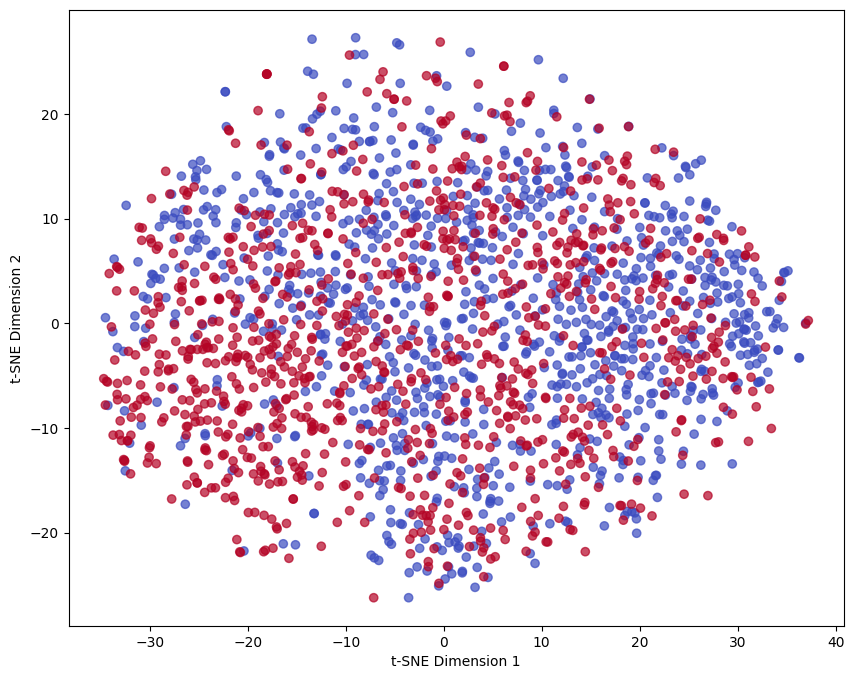

In [ ]:
# @title t-SNE 2D Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have already created the 'reviews_df' DataFrame

# Extract features (review vectors) and labels
features = reviews_df.drop('label', axis=1).values
labels = reviews_df['label'].values

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
tsne_results = tsne.fit_transform(features)

# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])

# Add labels to the t-SNE DataFrame
tsne_df['label'] = labels

# Plot t-SNE results with colors for labels
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['tsne1'], tsne_df['tsne2'], c=tsne_df['label'], cmap='coolwarm', alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
# @title t-SNE 3D Visualization
import pandas as pd
from sklearn.manifold import TSNE
import plotly.graph_objs as go

# Assuming you have already created the 'reviews_df' DataFrame

# Extract features (review vectors) and labels
features = reviews_df.drop('label', axis=1).values
labels = reviews_df['label'].values

# Initialize t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42)

# Fit and transform the data
tsne_results = tsne.fit_transform(features)

# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])

# Add labels to the t-SNE DataFrame
tsne_df['label'] = labels

# Create a Plotly scatter plot
scatter_plot = go.Scatter3d(
    x=tsne_df['tsne1'],
    y=tsne_df['tsne2'],
    z=tsne_df['tsne3'],
    mode='markers',
    marker=dict(
        size=5,
        color=tsne_df['label'],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create layout
layout = go.Layout(
    title='t-SNE Plot of Review Vectors with Labels (3D)',
    scene=dict(
        xaxis=dict(title='t-SNE Dimension 1'),
        yaxis=dict(title='t-SNE Dimension 2'),
        zaxis=dict(title='t-SNE Dimension 3')
    )
)

# Create figure and plot
fig = go.Figure(data=[scatter_plot], layout=layout)
fig.show()

In [ ]:
# @title Compare Classifiers { display-mode: "form" }
# @markdown This is a Classifier Comparison framework developed together with Evgenia Argyriadi during a previous assignment in the "Machine Learning and Computer Vision" class with Professor Protopapadakis.

# @markdown The code implements a framework for comparing the performance of different classifiers using various evaluation metrics such as accuracy, precision, recall, F1-score, and ROC-AUC. It conducts cross-validation, calculates these metrics for each fold, and aggregates the results. Additionally, it visualizes confusion matrices and identifies the best classifier based on a combined score derived from the evaluation metrics.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=1),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred)
    }
    return metrics

import random
import hashlib

# Returns a random color genarated from the model name
def generate_random_color(seed):
    seed_int = int(hashlib.sha256(seed.encode()).hexdigest(), 16)
    random.seed(seed_int)

    return "#{:02x}{:02x}{:02x}".format(
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)
    )

def create_colors_dict(models):
  colors_dict = {}
  for model_name in models.keys():
    color = generate_random_color(model_name)
    colors_dict[model_name] = color
  return colors_dict


from sklearn.model_selection import train_test_split

# Splits the DataFrame into training and testing sets (X_train, X_test, y_train, y_test)
def trainAndTest(df):
    X = df.drop(columns=[status])
    y = df[status]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def train_model(model, X_train, X_test, y_train):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    return y_pred_train, y_pred_test

def fill_df(results_df,  model_name,
            metrics_train, metrics_test, fold_num, col_names):

    # Calculate the metrics
    row_train = (
        model_name, 'Train', metrics_train['accuracy'], metrics_train['precision'], metrics_train['recall'],
        metrics_train['f1'], metrics_train['roc_auc'], metrics_train['sensitivity'], metrics_train['specificity'], fold_num
    )

    row_test = (
        model_name, 'Test', metrics_test['accuracy'], metrics_test['precision'], metrics_test['recall'],
        metrics_test['f1'], metrics_test['roc_auc'], metrics_test['sensitivity'], metrics_test['specificity'], fold_num
    )

    # Append the results to the DataFrame
    df2 = pd.DataFrame([row_train, row_test], columns=col_names)
    results_df = pd.concat([results_df, df2], ignore_index=True)

    return results_df

import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot a confusion matrix with customized labels
def plot_confusion_matrix(confusion_matrix, color, title):
    label_names = ["positive", "negative"]

    # Plot the confusion matrix using seaborn
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=sns.light_palette(color, as_cmap=True), xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{title}')

# Function to plot training and testing confusion matrices for a model
def plot_confusion_matrices(cm_train, cm_test, model_name, fold, colors_dict):

    # Create a single figure with subplots for training and testing confusion matrices
    plt.figure(figsize=(7, 3))

    # Get a custom color for each model name
    color = colors_dict[model_name]

    plt.suptitle(f'{model_name} - Fold {fold + 1}', fontsize=16)

    # Plot the training confusion matrix
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cm_train, color, title='Training Confusion Matrix')

    # Plot the testing confusion matrix
    plt.subplot(1, 2, 2)
    plot_confusion_matrix(cm_test, color, title='Testing Confusion Matrix')

    plt.tight_layout()
    plt.show()
    print()

def print_class_counts(y_train, y_test):
  class_labels = [1,0]

  print("Train Set:")
  print("Positive:", sum(y_train == class_labels[0]))
  print("Negative:", sum(y_train == class_labels[1]))
  print("-" * 30)

  print("Test Set:")
  print("Positive:", sum(y_test == class_labels[0]))
  print("Negative:", sum(y_test == class_labels[1]))
  print("-" * 30 + "\n")

def print_metrics(model_name, m_train, m_test):
    print(f"Model: {model_name}")
    print("Train Set - ", end="")
    for metric, value in m_train.items():
        print(f"{metric.capitalize()}: {value:.2f}", end=", ")
    print()
    print("Test Set  - ", end="")
    for metric, value in m_test.items():
        print(f"{metric.capitalize()}: {value:.2f}", end=", ")
    print("\n")

def metrics_and_confusion_matrix(y_train, pred_train, y_test, pred_test, model_name, fold_num):
    # Metrics
    metrics_train = calculate_metrics(y_train, pred_train)
    metrics_test = calculate_metrics(y_test, pred_test)
    print_metrics(model_name, metrics_train, metrics_test)

    # Confusion Matrices
    cm_train = confusion_matrix(y_train, pred_train)
    cm_test = confusion_matrix(y_test, pred_test)

    # print results
    sensitivity = cm_train[1,1]/(cm_train[1,0]+cm_train[1,1])
    metrics_train['sensitivity'] = sensitivity
    sensitivity1 = cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])
    metrics_test['sensitivity'] = sensitivity1

    print('Sensitivity : ', sensitivity1 )

    specificity = cm_train[1,1]/(cm_train[1,0]+cm_train[1,1])
    metrics_train['specificity'] = sensitivity1
    specificity1 = cm_test[0,0]/(cm_test[0,0]+cm_test[0,1])
    print('Specificity : ', specificity1)
    print()
    metrics_test['specificity'] = specificity1
    plot_confusion_matrices(cm_train, cm_test, model_name, fold_num, colors_dict)

    return metrics_train, metrics_test, cm_train, cm_test

from sklearn.metrics import confusion_matrix

def loops(X, y, models, df_to_fill,folds, col_names):
    avg_metrics_train = {model_name: {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']} for model_name in models}
    avg_metrics_test = {model_name: {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']} for model_name in models}

    for fold_num, (train_id, test_id) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_id].values
        y_train = y.iloc[train_id].values
        X_test = X.iloc[test_id].values
        y_test = y.iloc[test_id].values

        print(f"------------------------- Fold {fold_num + 1} ----------------------")
        # Class counts
        print_class_counts(y_train, y_test)

        predictions = {}
        thresholds = {}

        for model_name, model in models.items():
          # Train Models
          pred_train, pred_test = train_model(model, X_train, X_test, y_train)

          # Metrics and Confusion Matrices
          metrics_train, metrics_test, cm_train, cm_test = metrics_and_confusion_matrix(y_train,
                                             pred_train, y_test, pred_test, model_name, fold_num)

          # Add to results df
          df_to_fill = fill_df(df_to_fill, model_name, metrics_train, metrics_test, fold_num, col_names)

    return df_to_fill

from sklearn.preprocessing import MinMaxScaler
def normalize_df(df, columns_to_exclude):
  scaler = MinMaxScaler()
    # Get a list of columns to normalize by excluding the specified columns
  columns_to_normalize = [col for col in df.columns if col not in columns_to_exclude]

    # Create a DataFrame containing only the columns to be normalized
  normalized_data = df[columns_to_normalize]
  normalized_df= pd.DataFrame(scaler.fit_transform(normalized_data), columns=columns_to_normalize)
  for col in columns_to_exclude:
      normalized_df[col] = df[col]

  return normalized_df

from sklearn.model_selection import StratifiedKFold

def compare_classifiers(df, status, models_dict, N_SPLITS = 1):

    folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=9)

    col_names = ['Classifier', 'Set','Accuracy','Precision', 'Recall', 'F1','Roc-Auc', 'Sensitivity', 'Specificity', 'Fold Num']

    #df = normalize_df(df, ["label"])
    X = df.drop(columns=[status])
    # separate target values
    y = df[status]

    unbalanced_df = pd.DataFrame(columns=col_names)
    unbalanced_df = loops(X, y, models_dict, unbalanced_df, folds, col_names)
    unbalanced_df.to_csv('DataOutcomes.csv', index=False)

    return unbalanced_df, models_dict

from IPython.display import display
def find_best_classifier(df):
      # Filter rows where Set is Test
    test_data = df[df['Set'] == 'Test'].drop(columns=['Set', 'Fold Num'])

    # Group by Classifier and calculate the mean
    test_data_avg = test_data.groupby('Classifier').mean().reset_index()

    def custom_score(row):
      # You can adjust the weights for each metric based on their importance
      score = (0.5 * row['Accuracy']) + (0.3 * row['Precision']) + (0.2 * row['Recall'])
      return score

    # Apply custom scoring function to calculate a combined score
    test_data_avg['Combined_Score'] = test_data_avg.apply(custom_score, axis=1)

    # Find the classifier with the highest combined score
    best_classifier = test_data_avg.loc[test_data_avg['Combined_Score'].idxmax()]
    model_name = best_classifier['Classifier']

    display(test_data_avg)
    print("Best classifier based on combined score is:", model_name)

    return test_data_avg, model_name

------------------------- Fold 1 ----------------------
Train Set:
Positive: 667
Negative: 666
------------------------------
Test Set:
Positive: 333
Negative: 334
------------------------------

Model: LDA
Train Set - Accuracy: 0.90, Precision: 0.89, Recall: 0.91, F1: 0.90, Roc_auc: 0.90, 
Test Set  - Accuracy: 0.84, Precision: 0.84, Recall: 0.84, F1: 0.84, Roc_auc: 0.84, 

Sensitivity :  0.8408408408408409
Specificity :  0.8413173652694611



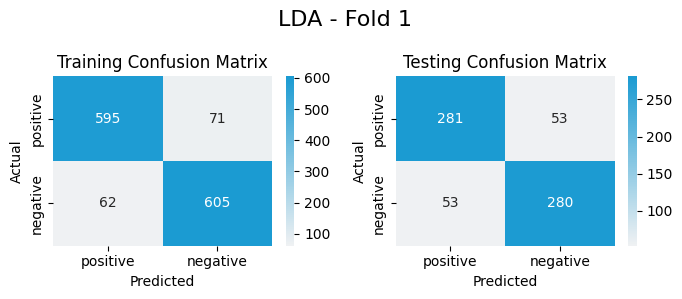


Model: Logistic Regression
Train Set - Accuracy: 0.69, Precision: 0.70, Recall: 0.69, F1: 0.69, Roc_auc: 0.69, 
Test Set  - Accuracy: 0.68, Precision: 0.69, Recall: 0.65, F1: 0.67, Roc_auc: 0.68, 

Sensitivity :  0.6546546546546547
Specificity :  0.7005988023952096



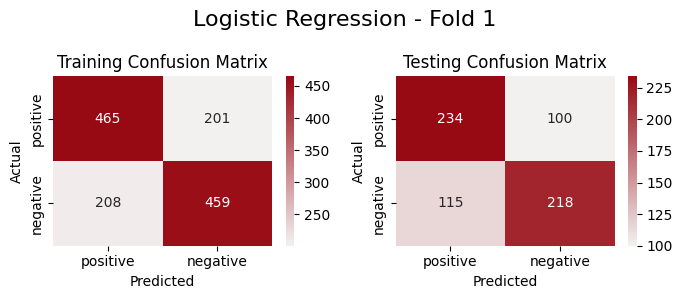


Model: Decision Tree
Train Set - Accuracy: 0.73, Precision: 0.71, Recall: 0.79, F1: 0.75, Roc_auc: 0.73, 
Test Set  - Accuracy: 0.67, Precision: 0.66, Recall: 0.72, F1: 0.69, Roc_auc: 0.67, 

Sensitivity :  0.7237237237237237
Specificity :  0.625748502994012



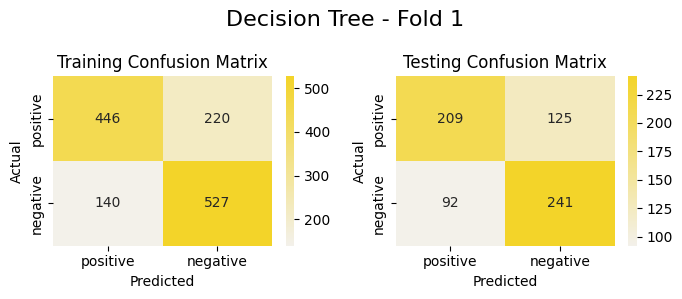


Model: Random Forest
Train Set - Accuracy: 0.79, Precision: 0.80, Recall: 0.78, F1: 0.79, Roc_auc: 0.79, 
Test Set  - Accuracy: 0.72, Precision: 0.74, Recall: 0.68, F1: 0.71, Roc_auc: 0.72, 

Sensitivity :  0.6846846846846847
Specificity :  0.7604790419161677



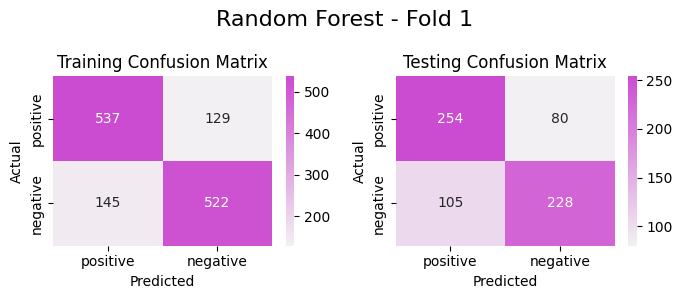


Model: kNN
Train Set - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1: 1.00, Roc_auc: 1.00, 
Test Set  - Accuracy: 0.64, Precision: 0.63, Recall: 0.65, F1: 0.64, Roc_auc: 0.64, 

Sensitivity :  0.6516516516516516
Specificity :  0.6197604790419161



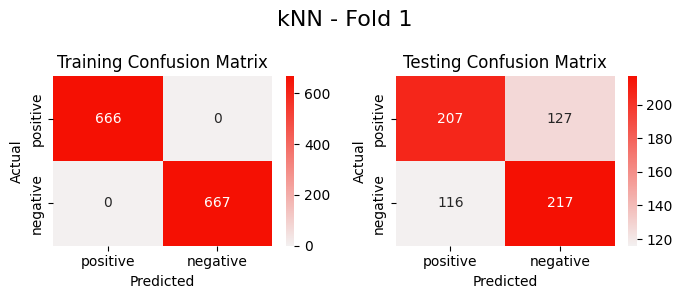


Model: Naive Bayes
Train Set - Accuracy: 0.70, Precision: 0.71, Recall: 0.69, F1: 0.70, Roc_auc: 0.70, 
Test Set  - Accuracy: 0.69, Precision: 0.71, Recall: 0.65, F1: 0.68, Roc_auc: 0.69, 

Sensitivity :  0.6546546546546547
Specificity :  0.7305389221556886



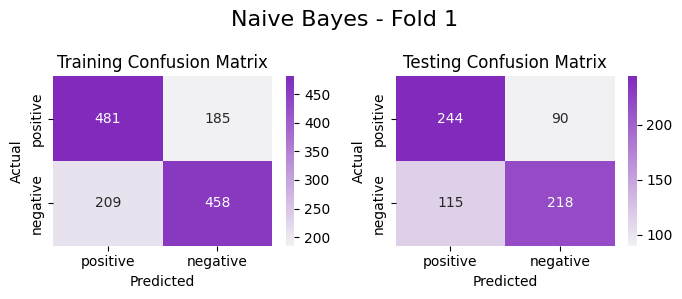


Model: Support Vector Machines
Train Set - Accuracy: 0.66, Precision: 0.64, Recall: 0.75, F1: 0.69, Roc_auc: 0.66, 
Test Set  - Accuracy: 0.66, Precision: 0.64, Recall: 0.73, F1: 0.68, Roc_auc: 0.66, 

Sensitivity :  0.7297297297297297
Specificity :  0.5988023952095808



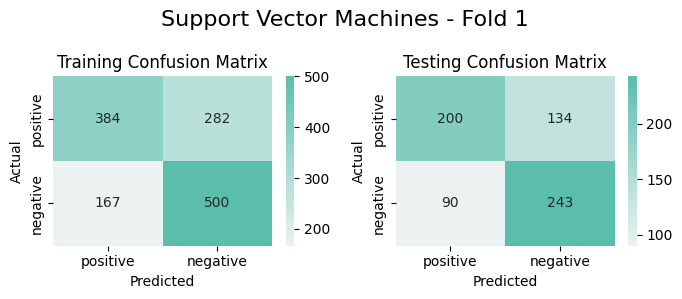


------------------------- Fold 2 ----------------------
Train Set:
Positive: 666
Negative: 667
------------------------------
Test Set:
Positive: 334
Negative: 333
------------------------------

Model: LDA
Train Set - Accuracy: 0.91, Precision: 0.91, Recall: 0.90, F1: 0.91, Roc_auc: 0.91, 
Test Set  - Accuracy: 0.85, Precision: 0.85, Recall: 0.86, F1: 0.85, Roc_auc: 0.85, 

Sensitivity :  0.8592814371257484
Specificity :  0.8438438438438438



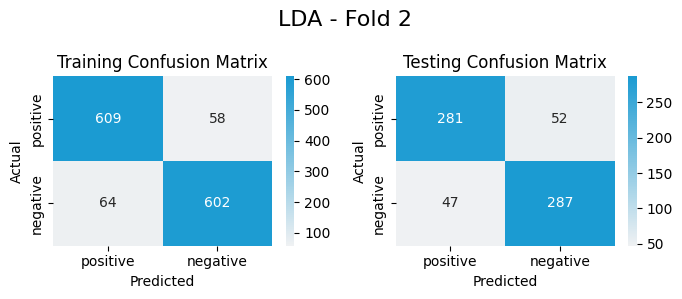


Model: Logistic Regression
Train Set - Accuracy: 0.69, Precision: 0.69, Recall: 0.67, F1: 0.68, Roc_auc: 0.69, 
Test Set  - Accuracy: 0.68, Precision: 0.69, Recall: 0.66, F1: 0.67, Roc_auc: 0.68, 

Sensitivity :  0.655688622754491
Specificity :  0.7027027027027027



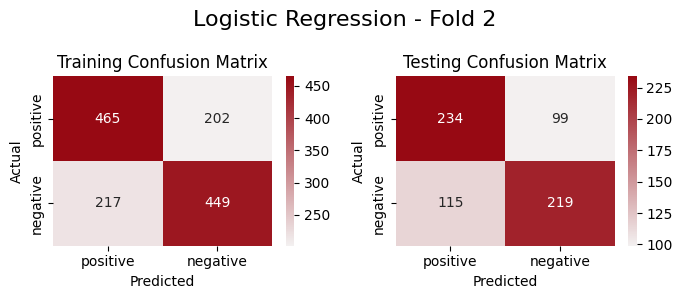


Model: Decision Tree
Train Set - Accuracy: 0.71, Precision: 0.74, Recall: 0.65, F1: 0.69, Roc_auc: 0.71, 
Test Set  - Accuracy: 0.63, Precision: 0.64, Recall: 0.58, F1: 0.61, Roc_auc: 0.63, 

Sensitivity :  0.5808383233532934
Specificity :  0.6756756756756757



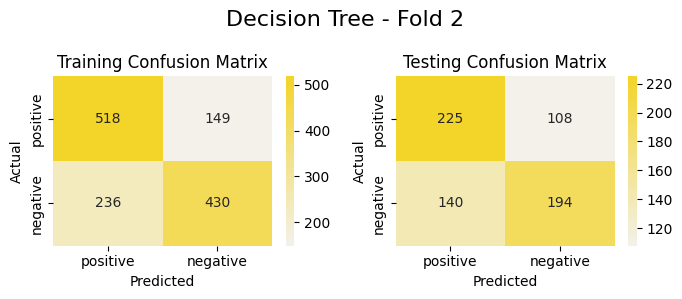


Model: Random Forest
Train Set - Accuracy: 0.80, Precision: 0.82, Recall: 0.79, F1: 0.80, Roc_auc: 0.80, 
Test Set  - Accuracy: 0.71, Precision: 0.71, Recall: 0.70, F1: 0.70, Roc_auc: 0.71, 

Sensitivity :  0.6976047904191617
Specificity :  0.7147147147147147



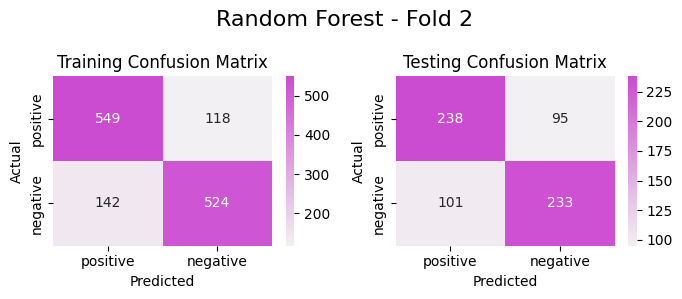


Model: kNN
Train Set - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1: 1.00, Roc_auc: 1.00, 
Test Set  - Accuracy: 0.64, Precision: 0.64, Recall: 0.64, F1: 0.64, Roc_auc: 0.64, 

Sensitivity :  0.6377245508982036
Specificity :  0.6426426426426426



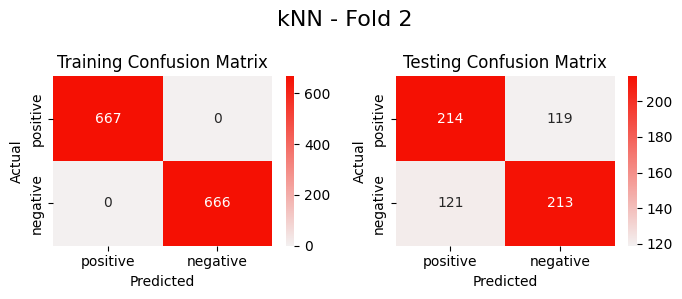


Model: Naive Bayes
Train Set - Accuracy: 0.70, Precision: 0.72, Recall: 0.66, F1: 0.69, Roc_auc: 0.70, 
Test Set  - Accuracy: 0.67, Precision: 0.68, Recall: 0.65, F1: 0.67, Roc_auc: 0.67, 

Sensitivity :  0.6526946107784432
Specificity :  0.6936936936936937



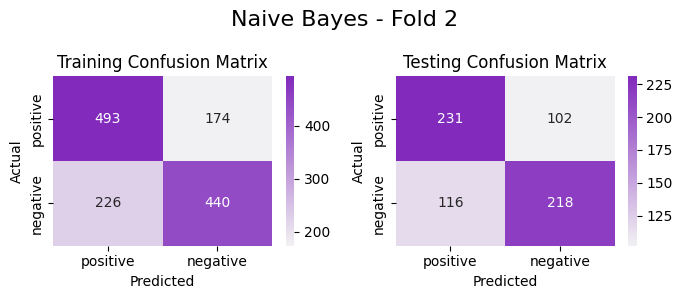


Model: Support Vector Machines
Train Set - Accuracy: 0.68, Precision: 0.69, Recall: 0.64, F1: 0.66, Roc_auc: 0.68, 
Test Set  - Accuracy: 0.67, Precision: 0.69, Recall: 0.63, F1: 0.66, Roc_auc: 0.67, 

Sensitivity :  0.6347305389221557
Specificity :  0.7147147147147147



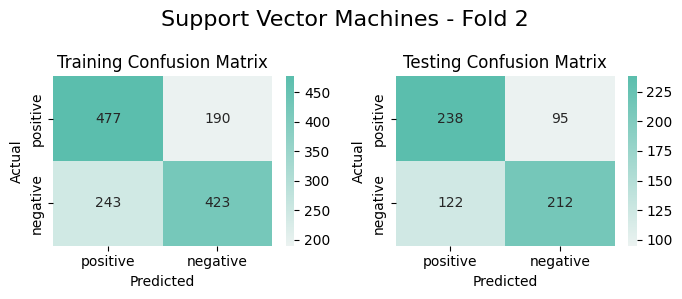


------------------------- Fold 3 ----------------------
Train Set:
Positive: 667
Negative: 667
------------------------------
Test Set:
Positive: 333
Negative: 333
------------------------------

Model: LDA
Train Set - Accuracy: 0.90, Precision: 0.90, Recall: 0.91, F1: 0.90, Roc_auc: 0.90, 
Test Set  - Accuracy: 0.82, Precision: 0.82, Recall: 0.83, F1: 0.82, Roc_auc: 0.82, 

Sensitivity :  0.8288288288288288
Specificity :  0.8138138138138138



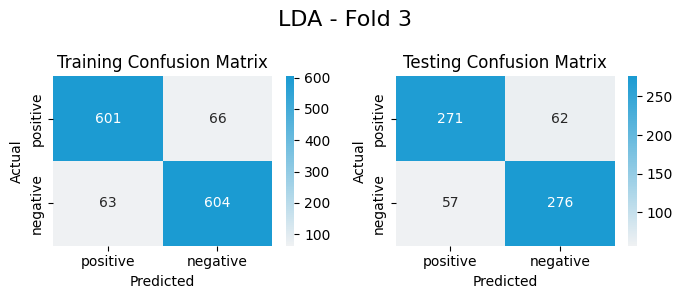


Model: Logistic Regression
Train Set - Accuracy: 0.69, Precision: 0.69, Recall: 0.67, F1: 0.68, Roc_auc: 0.69, 
Test Set  - Accuracy: 0.68, Precision: 0.67, Recall: 0.69, F1: 0.68, Roc_auc: 0.68, 

Sensitivity :  0.6906906906906907
Specificity :  0.6636636636636637



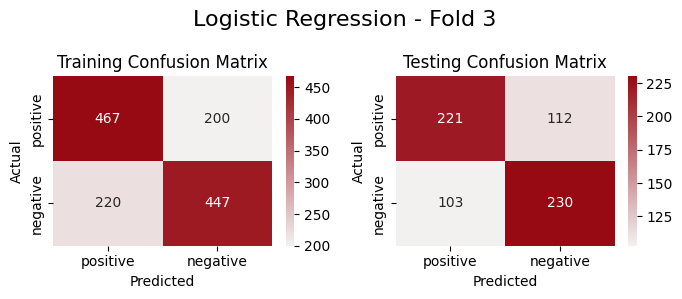


Model: Decision Tree
Train Set - Accuracy: 0.74, Precision: 0.72, Recall: 0.77, F1: 0.74, Roc_auc: 0.74, 
Test Set  - Accuracy: 0.66, Precision: 0.65, Recall: 0.70, F1: 0.68, Roc_auc: 0.66, 

Sensitivity :  0.6996996996996997
Specificity :  0.6276276276276276



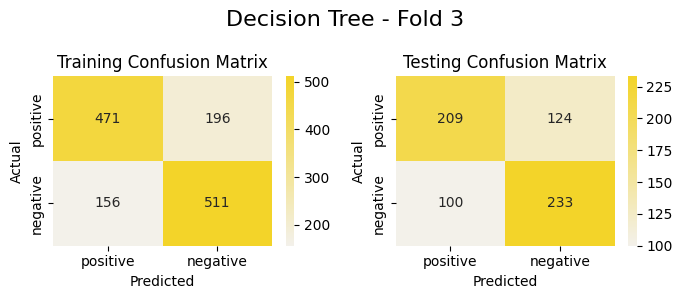


Model: Random Forest
Train Set - Accuracy: 0.79, Precision: 0.80, Recall: 0.78, F1: 0.79, Roc_auc: 0.79, 
Test Set  - Accuracy: 0.71, Precision: 0.71, Recall: 0.71, F1: 0.71, Roc_auc: 0.71, 

Sensitivity :  0.7117117117117117
Specificity :  0.7117117117117117



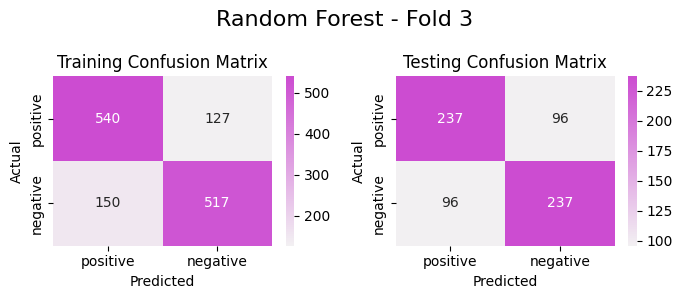


Model: kNN
Train Set - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1: 1.00, Roc_auc: 1.00, 
Test Set  - Accuracy: 0.69, Precision: 0.70, Recall: 0.67, F1: 0.68, Roc_auc: 0.69, 

Sensitivity :  0.6666666666666666
Specificity :  0.7087087087087087



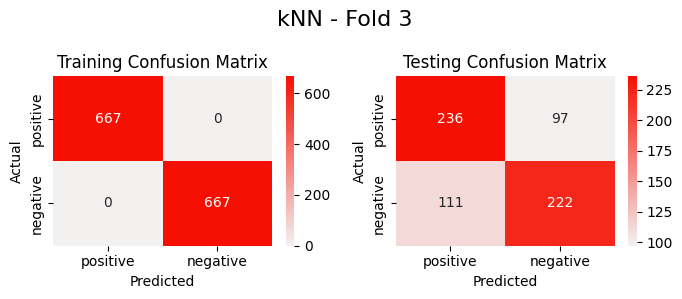


Model: Naive Bayes
Train Set - Accuracy: 0.70, Precision: 0.72, Recall: 0.66, F1: 0.69, Roc_auc: 0.70, 
Test Set  - Accuracy: 0.69, Precision: 0.69, Recall: 0.69, F1: 0.69, Roc_auc: 0.69, 

Sensitivity :  0.6876876876876877
Specificity :  0.6906906906906907



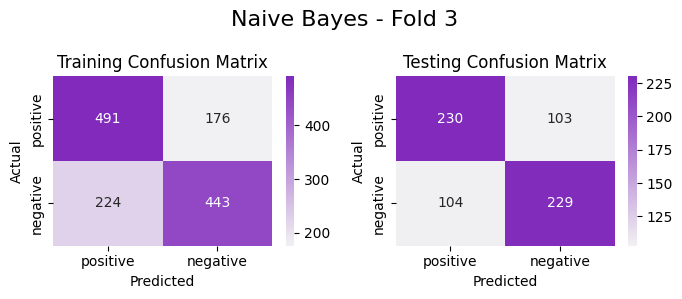


Model: Support Vector Machines
Train Set - Accuracy: 0.67, Precision: 0.66, Recall: 0.68, F1: 0.67, Roc_auc: 0.67, 
Test Set  - Accuracy: 0.67, Precision: 0.66, Recall: 0.70, F1: 0.68, Roc_auc: 0.67, 

Sensitivity :  0.6996996996996997
Specificity :  0.6336336336336337



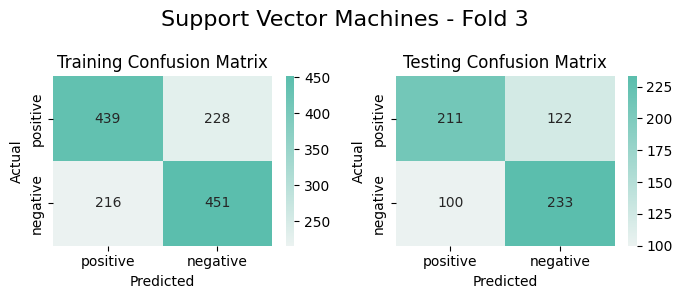

,Classifier,Accuracy,Precision,Recall,F1,Roc-Auc,Sensitivity,Specificity,Combined_Score
0,Decision Tree,0.655504,0.651172,0.668087,0.658327,0.655552,0.668087,0.643017,0.656721
1,LDA,0.837992,0.834672,0.842984,0.838797,0.837988,0.842984,0.832992,0.837994
2,Logistic Regression,0.678000,0.682243,0.667011,0.674333,0.678000,0.667011,0.688988,0.677075
3,Naive Bayes,0.685002,0.692934,0.665012,0.678525,0.684993,0.665012,0.704974,0.683384
4,Random Forest,0.713499,0.720779,0.698000,0.709009,0.713484,0.698000,0.728968,0.712583
5,Support Vector Machines,0.668499,0.663818,0.688053,0.674433,0.668552,0.688053,0.649050,0.671006
6,kNN,0.654517,0.656102,0.652014,0.653895,0.654526,0.652014,0.657037,0.654492


Best classifier based on combined score is: LDA


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

models_dict = {
    "LDA": LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=3, n_estimators=100, random_state=42),
    "kNN" : KNeighborsClassifier(2, weights='distance'),
    "Naive Bayes" : GaussianNB(),
    "Support Vector Machines" : svm.SVC(kernel='linear')
}
colors_dict = create_colors_dict(models_dict)


results_df, trained_models_dict = compare_classifiers(reviews_df, "label", models_dict, 3)
avg_df, trained_model_name = find_best_classifier(results_df)

trained_model = trained_models_dict[trained_model_name]

In [17]:
display(avg_df)

,Classifier,Accuracy,Precision,Recall,F1,Roc-Auc,Sensitivity,Specificity,Combined_Score
0,Decision Tree,0.655504,0.651172,0.668087,0.658327,0.655552,0.668087,0.643017,0.656721
1,LDA,0.837992,0.834672,0.842984,0.838797,0.837988,0.842984,0.832992,0.837994
2,Logistic Regression,0.678000,0.682243,0.667011,0.674333,0.678000,0.667011,0.688988,0.677075
3,Naive Bayes,0.685002,0.692934,0.665012,0.678525,0.684993,0.665012,0.704974,0.683384
4,Random Forest,0.713499,0.720779,0.698000,0.709009,0.713484,0.698000,0.728968,0.712583
5,Support Vector Machines,0.668499,0.663818,0.688053,0.674433,0.668552,0.688053,0.649050,0.671006
6,kNN,0.654517,0.656102,0.652014,0.653895,0.654526,0.652014,0.657037,0.654492
